# Sistema de Recomendação de vinhos

## 1ª Questão
Análise exploratória (3 pontos) : realize as análises deste conjunto de dados, crie gráficos e anote as suas idéias.

In [41]:
!pip3 install -U spacy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 6.3 MB 4.5 MB/s 
     |████████████████████████████████| 821 kB 32.5 MB/s 
  Attempting uninstall: thinc
    Found existing installation: thinc 8.0.17
    Uninstalling thinc-8.0.17:
      Successfully uninstalled thinc-8.0.17
  Attempting uninstall: spacy
    Found existing installation: spacy 3.3.1
    Uninstalling spacy-3.3.1:
      Successfully uninstalled spacy-3.3.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
en-core-web-sm 3.3.0 requires spacy<3.4.0,>=3.3.0.dev0, but you have spacy 3.4.0 which is incompatible.


In [42]:
!python3 -m spacy download en

2022-07-16 17:53:34.775183: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
⚠ As of spaCy v3.0, shortcuts like 'en' are deprecated. Please use the
full pipeline package name 'en_core_web_sm' instead.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 12.8 MB 3.0 MB/s 
  Attempting uninstall: en-core-web-sm
    Found existing installation: en-core-web-sm 3.3.0
    Uninstalling en-core-web-sm-3.3.0:
      Successfully uninstalled en-core-web-sm-3.3.0
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [46]:
# Importando os módulos
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='darkgrid')

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

from sklearn.preprocessing import LabelEncoder
from sklearn.cluster import KMeans

import spacy
nlp = spacy.load('en_core_web_sm')

from yellowbrick.cluster import KElbowVisualizer


In [2]:
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [3]:
# Importando o arquivo csv
wine = pd.read_csv('/content/drive/MyDrive/Datasets/winemag-data-130k-v2.csv')
wine.head()

,Unnamed: 0,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
0,0,Italy,"Aromas include tropical fruit, broom, brimston...",Vulkà Bianco,87,NaN,Sicily & Sardinia,Etna,NaN,Kerin O’Keefe,@kerinokeefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia
1,1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.0,Douro,NaN,NaN,Roger Voss,@vossroger,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos
2,2,US,"Tart and snappy, the flavors of lime flesh and...",NaN,87,14.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm
3,3,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,NaN,Alexander Peartree,NaN,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian
4,4,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks


### Dicionário dos dados

- **country**: País em o vinho foi produzido.
- **description**: descrição do produto.
- **designation**: a vinheira de onde são tiradas as uvas para produzir o vinho.
- **points**: Número de pontos do vinho entre 1 a 100.
- **price**: Preço da garrafa.
- **province**: Provincia ou o Estado de onde o vinho foi produzido.
- **region_2**: Especifica outra região em que o vinho também foi produzido, no caso de houver um.
- **taster_name**: Nome da pessoa que provou o vinho.
- **taster_twitter_handle**: Endereço do seu twitter.
- **title**: titulo da *review* do vinho.
- **variety**: Qual foi o tipo de uva usada para se produzir o vinho.
- **winery**: Nome da vinheira onde o vinho foi produzido.

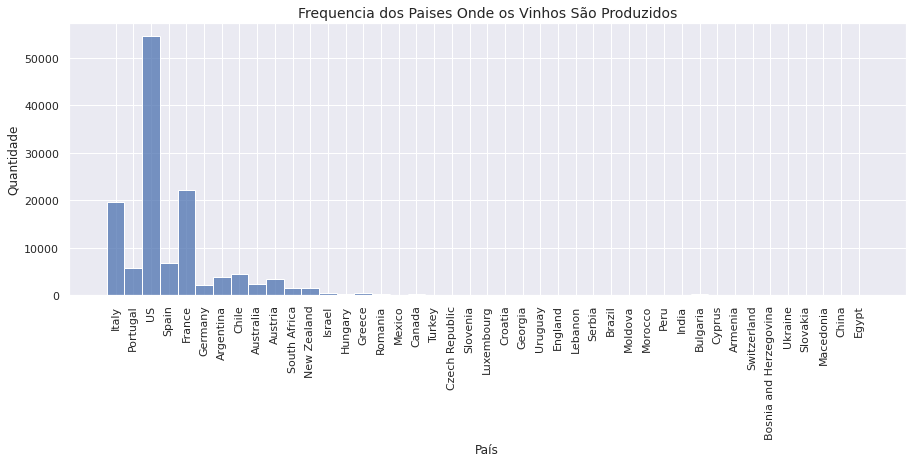

In [4]:
plt.figure(figsize=(15,5))
plt.title('Frequencia dos Paises Onde os Vinhos São Produzidos',fontsize=14)
sns.histplot(x='country',data=wine)
plt.xlabel('País')
plt.ylabel('Quantidade')
plt.xticks(rotation=90);

Temos que a maioria das reviews são de vinhos que foram produzido nos Estados Unidos, com mais de 50 mil, e abaixo dele, com cerca de 20 mil estão Itália e França. Por isso preferi me focar nas reviews dos vinhos produzidos nos Estados Unidos, para uma melhor visão.

In [5]:
# Criando o dataframe para os Estados Unidos
wine_us = wine[wine['country']=='US']
wine_us.drop('country',axis=1,inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [6]:
wine_us.head()

,Unnamed: 0,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
2,2,"Tart and snappy, the flavors of lime flesh and...",NaN,87,14.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm
3,3,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,NaN,Alexander Peartree,NaN,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian
4,4,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks
10,10,"Soft, supple plum envelopes an oaky structure ...",Mountain Cuvée,87,19.0,California,Napa Valley,Napa,Virginie Boone,@vboone,Kirkland Signature 2011 Mountain Cuvée Caberne...,Cabernet Sauvignon,Kirkland Signature
12,12,"Slightly reduced, this wine offers a chalky, t...",NaN,87,34.0,California,Alexander Valley,Sonoma,Virginie Boone,@vboone,Louis M. Martini 2012 Cabernet Sauvignon (Alex...,Cabernet Sauvignon,Louis M. Martini


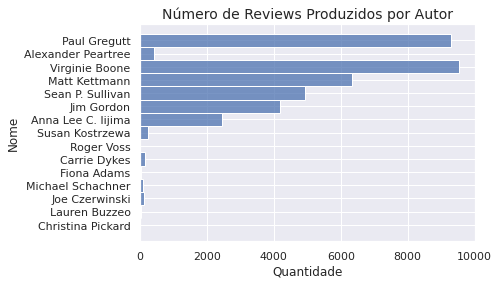

In [7]:
plt.title('Número de Reviews Produzidos por Autor',fontsize=14)
sns.histplot(y='taster_name',data=wine_us)
plt.xlabel('Quantidade')
plt.ylabel('Nome');

O autores com mais reviews neste dataset dos Estados Unidos são Paul Gregutt e Virginie Boone.

In [8]:
wine_us.groupby('taster_name').mean().iloc[-1,:]

Unnamed: 0    65633.547866
points           89.213379
price            46.621963
Name: Virginie Boone, dtype: float64

O valor médio da autora que fez mais reviews tem um valor médio nos pontos em tornos de 89,21 pontos e e o preço do vinho está em torno de 46,62.

Text(0.5, 0, 'Quantidade')

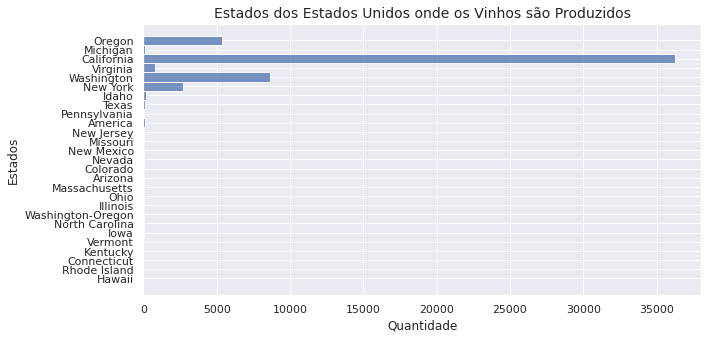

In [9]:
plt.figure(figsize=(10,5))
plt.title('Estados dos Estados Unidos onde os Vinhos são Produzidos',fontsize=14)
sns.histplot(y='province',data=wine_us)
plt.ylabel('Estados')
plt.xlabel('Quantidade')

Os Estados onde tem mais vinhos sendo produzidos é a California, em torno de 35 mil, valor discrepante, com parado a utros Estados como Oregon, que está em torno de 5 mil e Washington próximo a 10 mil.

In [10]:
wine_us.isna().sum()[6:8]

region_1     278
region_2    3993
dtype: int64

Agora iremos verificar os Estado com as maiores pontuações, não será possivel as regiões pois as mesma tem muito valores vazios, como pode ser visto acima em que a região 1 temos 278 valores vazios e o 2 3993.

In [11]:
wine_us.groupby('province').mean()

,Unnamed: 0,points,price
province,,,
America,64049.315789,86.505263,19.894737
Arizona,65322.024390,84.926829,29.200000
California,65449.398047,88.627776,39.041048
Colorado,64514.955882,86.117647,32.985294
Connecticut,66162.333333,84.000000,15.333333
Hawaii,108866.000000,87.000000,28.000000
Idaho,67639.265625,86.598958,20.768421
Illinois,58834.666667,84.500000,32.333333
Iowa,51110.500000,83.000000,15.500000


Podemos ver pelo dataframe acima que o Estado com maior pontos é Rhode Island com 90 pontos e o mais barato no preço é Ohio com 13,75.

Text(0, 0.5, 'Frequência')

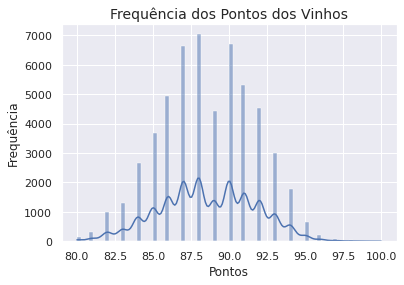

In [12]:
plt.title('Frequência dos Pontos dos Vinhos',fontsize=14)
sns.histplot(x='points',data=wine_us,kde=True)
plt.xlabel('Pontos')
plt.ylabel('Frequência')


Os pontos estão mais concentrados em torno de 87,5 pontos e 90 pontos.

Text(0.5, 0, 'Preço')

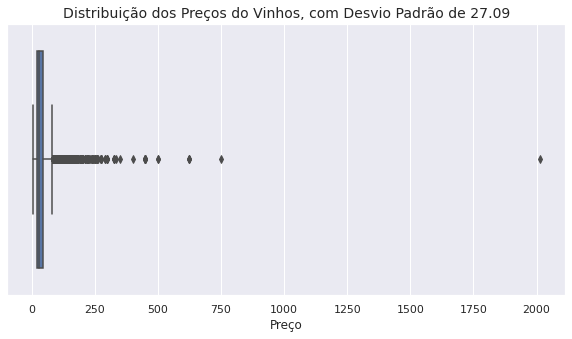

In [13]:
plt.figure(figsize=(10,5))
desvio_preço = round(np.std(wine_us['price']),2)
plt.title(f'Distribuição dos Preços do Vinhos, com Desvio Padrão de {desvio_preço}',
          fontsize=14)
sns.boxplot(x='price',data=wine_us)
plt.xlabel('Preço')

Pela questão dos preços,temos valores muitos discrepantes, como pode mostrar o desvio padrão no titulo.Neste sentido irá ser excluido o valores acima de 400 porque dificilmente alguém ira compra um vinho tão mais caro do que comprou, e esses preços presentes não se tem produto próximo que tenham esse valor

In [14]:
wineme = wine_us[wine_us['price']<401]
desme = round(np.std(wineme['price']),2)
print(desme)

24.57


Text(0.5, 0, 'Preço')

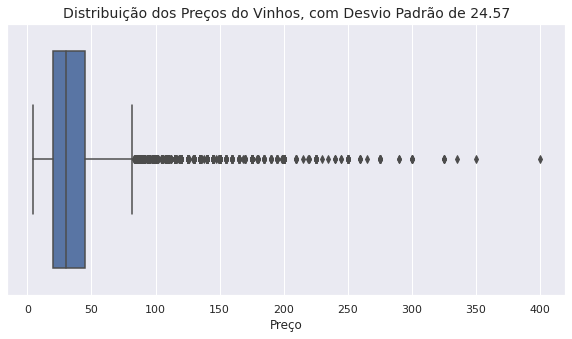

In [15]:
plt.figure(figsize=(10,5))

plt.title(f'Distribuição dos Preços do Vinhos, com Desvio Padrão de {desme}',
          fontsize=14)
sns.boxplot(x='price',data=wineme)
plt.xlabel('Preço')

In [16]:
wine_us.sort_values(by='price').iloc[0,:]

Unnamed: 0                                                           64590
description              There's a lot going on in this Merlot, which i...
designation                                                            NaN
points                                                                  86
price                                                                  4.0
province                                                        California
region_1                                                        California
region_2                                                  California Other
taster_name                                                            NaN
taster_twitter_handle                                                  NaN
title                                        Bandit NV Merlot (California)
variety                                                             Merlot
winery                                                              Bandit
Name: 64590, dtype: objec

Esse é o vinho mais barato 

In [17]:
wine_us.sort_values(by='price',ascending=False).iloc[0,:]

Unnamed: 0                                                          120391
description              The nose on this single-vineyard wine from a s...
designation                                            Roger Rose Vineyard
points                                                                  91
price                                                               2013.0
province                                                        California
region_1                                                       Arroyo Seco
region_2                                                     Central Coast
taster_name                                                  Matt Kettmann
taster_twitter_handle                                        @mattkettmann
title                    Blair 2013 Roger Rose Vineyard Chardonnay (Arr...
variety                                                         Chardonnay
winery                                                               Blair
Name: 120391, dtype: obje

Esse vinho mais caro

In [18]:
uvas = wine_us.groupby('variety').mean()
uvas.drop('Unnamed: 0',axis=1,inplace=True)
uvas.reset_index(inplace=True)
uvas.sort_values(by='points',ascending=False)

,variety,points,price
213,Syrah-Petit Verdot,94.0,49.0
122,Moscato Giallo,94.0,16.0
172,Riesling-Chardonnay,94.0,40.0
232,Touriga Nacional Blend,93.0,16.0
219,Tannat-Syrah,93.0,40.0
...,...,...,...
115,Merlot-Petite Verdot,83.0,20.0
48,Chardonel,83.0,11.0
34,Cabernet Sauvignon-Shiraz,83.0,9.0
165,Prosecco,82.0,28.0


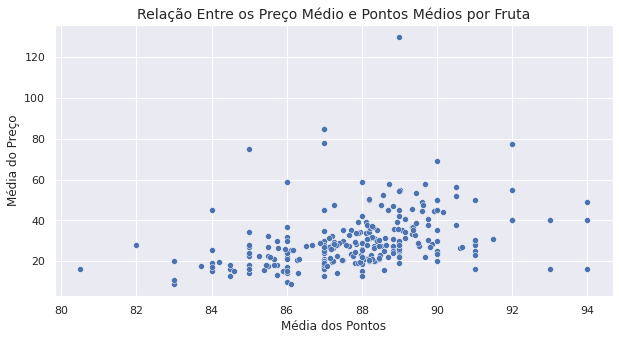

In [19]:
plt.figure(figsize=(10,5))
plt.title('Relação Entre os Preço Médio e Pontos Médios por Fruta',fontsize=14)
sns.scatterplot(x='points',y='price',data=uvas)
plt.xlabel('Média dos Pontos')
plt.ylabel('Média do Preço');

Quanto as frutas, as que tem o pontos médios mais altos são *Syrah-Petit Verdot, Moscato Giallo e Riesling-Chardonnay*, todos com ponto médio de 94 e os menor é o *Chancellor* com 80.5 pontos, interesante observar que o preço médio do *Syrah-Petit Verdot* é de 49 e do *Moscato Giallo* é de 16, mostrando que não necessariamente o vinhor com maior ponto, nãovai ter um preço médio bem alto. Isso pode ser melhor visto no gráfico de dispersão acima.

Text(0, 0.5, 'Vinheteira')

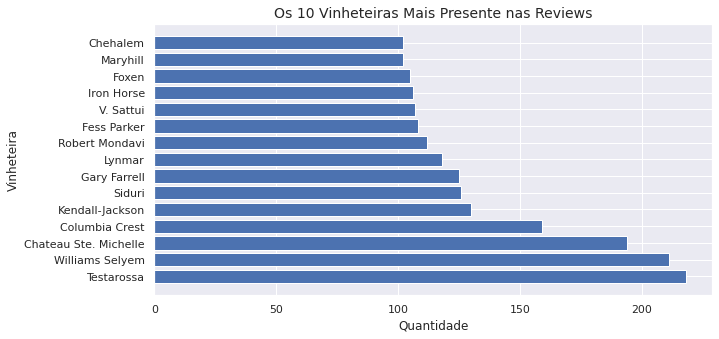

In [20]:
plt.figure(figsize=(10,5))
plt.title('Os 10 Vinheteiras Mais Presente nas Reviews',fontsize=14)
plt.barh(wine_us['winery'].value_counts().index[0:15],wine_us['winery'].value_counts()[0:15])
plt.xlabel('Quantidade')
plt.ylabel('Vinheteira')

## 2ª Questão

(3 pontos) Sistema de recomendação: faça a construção de seu sistema de recomendação

### Fazendo o Pré-processamento

In [21]:
# Verificando os dados faltantes
wine_us.isna().sum()

Unnamed: 0                   0
description                  0
designation              17596
points                       0
price                      239
province                     0
region_1                   278
region_2                  3993
taster_name              16774
taster_twitter_handle    19763
title                        0
variety                      0
winery                       0
dtype: int64

Como as colunas region_1,region_2, taster_name, taster_twitter_handle e designation tem muitos valores nulo, elas vão ser desconsideradas.

In [22]:
wine_us.drop(['designation','region_1','region_2','taster_name','taster_twitter_handle'],axis=1,
             inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [23]:
wine_us.columns

Index(['Unnamed: 0', 'description', 'points', 'price', 'province', 'title',
       'variety', 'winery'],
      dtype='object')

Sobre o valor do preço, ão ser apagdo porque temos poucos valores e como uma variavel importante, acredito que não seria interessante colocar um valor no lugar.

In [24]:
wine_us.dropna(inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


In [25]:
wine_us.isna().sum()

Unnamed: 0     0
description    0
points         0
price          0
province       0
title          0
variety        0
winery         0
dtype: int64

In [26]:
# Removendo os stop words das colunas descripion e title
stop = stopwords.words('english')


In [27]:
wine_us['description'] = wine_us['description'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
wine_us['title'] = wine_us['title'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [28]:
# Aplicando lemantização
def lema(coluna):
  lema = []
  wnl = WordNetLemmatizer()
  lista = list(coluna)
  for i in range(len(lista)):
    lista_le = nltk.word_tokenize(lista[i])
    junta = ' '.join([wnl.lemmatize(words) for words in lista_le])
    lema.append(junta)
  coluna = lema
  return coluna


In [29]:
wine_us['description'] = lema(wine_us['description'])
wine_us['title'] = lema(wine_us['title'])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


Tratamento nas strings, deixando tudo minusculo.

In [30]:
wine_us['description'] = wine_us['description'].str.lower()
wine_us['title'] = wine_us['title'].str.lower()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [31]:
wine_us['variety'] = wine_us['variety'].str.lower()
wine_us['winery'] = wine_us['winery'].str.lower()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [32]:
wine_us.head()

,Unnamed: 0,description,points,price,province,title,variety,winery
2,2,"tart snappy , flavor lime flesh rind dominate ...",87,14.0,Oregon,rainstorm 2013 pinot gris ( willamette valley ),pinot gris,rainstorm
3,3,"pineapple rind , lemon pith orange blossom sta...",87,13.0,Michigan,st. julian 2013 reserve late harvest riesling ...,riesling,st. julian
4,4,"much like regular bottling 2012 , come across ...",87,65.0,Oregon,sweet cheeks 2012 vintner 's reserve wild chil...,pinot noir,sweet cheeks
10,10,"soft , supple plum envelope oaky structure cab...",87,19.0,California,kirkland signature 2011 mountain cuvée caberne...,cabernet sauvignon,kirkland signature
12,12,"slightly reduced , wine offer chalky , tannic ...",87,34.0,California,louis m. martini 2012 cabernet sauvignon ( ale...,cabernet sauvignon,louis m. martini


In [33]:
wine_us.reset_index(inplace=True) 

In [34]:
wine_us.drop('index',axis=1,inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [35]:
vinho_u = []
for i in wine_us.index:
  a = f'vinho{i}'
  vinho_u.append(a)


In [36]:
wine_us.drop('Unnamed: 0',axis=1,inplace=True) 
wine_us['name'] = vinho_u

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [37]:
wine_us['name'] = wine_us['name'].str.replace('vinho','')
wine_us['name'] = wine_us['name'].astype(int)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [38]:
le = LabelEncoder()
le.fit(wine_us['variety'])
wine_us['variety'] = le.transform(wine_us['variety'])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [39]:
le.fit(wine_us['province'])
wine_us['province'] = le.transform(wine_us['province'])

le.fit(wine_us['winery'])
wine_us['winery'] = le.transform(wine_us['winery'])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [82]:
wine_us.drop_duplicates(inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


In [83]:
wine_us.head()

,description,points,price,province,title,variety,winery,name,cluster
0,"tart snappy , flavor lime flesh rind dominate ...",87,14.0,19,rainstorm 2013 pinot gris ( willamette valley ),154,3823,0,0
1,"pineapple rind , lemon pith orange blossom sta...",87,13.0,11,st. julian 2013 reserve late harvest riesling ...,171,4479,1,3
2,"much like regular bottling 2012 , come across ...",87,65.0,19,sweet cheeks 2012 vintner 's reserve wild chil...,158,4609,2,3
3,"soft , supple plum envelope oaky structure cab...",87,19.0,2,kirkland signature 2011 mountain cuvée caberne...,27,2575,3,2
4,"slightly reduced , wine offer chalky , tannic ...",87,34.0,2,louis m. martini 2012 cabernet sauvignon ( ale...,27,2855,4,2


Para fazer o sistema de recomendo vai ser utilizado esses três passos:
- Usar clusterização para separar e assim trabalhar com meno volume de dados;
- Pegar preços próximo ao vinho pedido;
- vericar quais são as reviews que tem maior similaridade, a partir disso as três mais próximas vão ser as recomendadas.

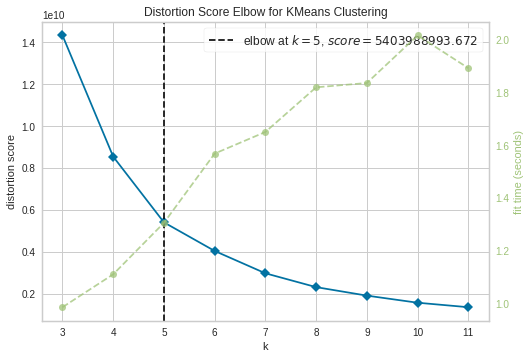

In [84]:
# Usnado as variavelis numericas para aplicar cluster

# Aplicando o metodo do cotovelo
wine_us_n = wine_us[['points','price','province','variety','winery']] # pegando as variaveis númericas

cotovelo = KElbowVisualizer(KMeans(),k=(3,12)) # Criando o gráfico
cotovelo.fit(wine_us_n)
cotovelo.show()

In [85]:
kmean = KMeans(n_clusters=5).fit(wine_us_n)

In [86]:
wine_us['cluster'] = kmean.labels_

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [87]:
wine_us.head()

,description,points,price,province,title,variety,winery,name,cluster
0,"tart snappy , flavor lime flesh rind dominate ...",87,14.0,19,rainstorm 2013 pinot gris ( willamette valley ),154,3823,0,4
1,"pineapple rind , lemon pith orange blossom sta...",87,13.0,11,st. julian 2013 reserve late harvest riesling ...,171,4479,1,1
2,"much like regular bottling 2012 , come across ...",87,65.0,19,sweet cheeks 2012 vintner 's reserve wild chil...,158,4609,2,1
3,"soft , supple plum envelope oaky structure cab...",87,19.0,2,kirkland signature 2011 mountain cuvée caberne...,27,2575,3,0
4,"slightly reduced , wine offer chalky , tannic ...",87,34.0,2,louis m. martini 2012 cabernet sauvignon ( ale...,27,2855,4,0


In [88]:
# Exemplo com o vinho 0

primeira = wine_us.iloc[0]
primeira

description    tart snappy , flavor lime flesh rind dominate ...
points                                                        87
price                                                       14.0
province                                                      19
title            rainstorm 2013 pinot gris ( willamette valley )
variety                                                      154
winery                                                      3823
name                                                           0
cluster                                                        4
Name: 0, dtype: object

In [89]:
wine_cl = wine_us[wine_us['cluster']==primeira[-1]]
wine_cl.drop(wine_cl.index[0],inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [90]:
wine_cl.head()

,description,points,price,province,title,variety,winery,name,cluster
6,"red fruit aroma pervade nose , cigar box menth...",87,32.0,24,quiévremont 2012 meritage ( virginia ),109,3803,6,4
7,ripe aroma dark berry mingle ample note black ...,87,23.0,24,quiévremont 2012 vin de maison red ( virginia ),166,3803,7,4
16,"the clean , brisk mouthfeel give slightly oake...",86,14.0,2,robert hall 2011 sauvignon blanc ( paso robles ),188,3968,16,4
20,"this show jelly-like flavor orange pear , eart...",85,30.0,2,rustridge 2010 estate bottled chardonnay ( nap...,49,4065,20,4
23,"syrupy dense , wine jammy plum vanilla , indet...",86,100.0,2,okapi 2013 estate cabernet sauvignon ( napa va...,27,3417,23,4


In [91]:
# Verificando os preços próximos
wine_cl = wine_cl[wine_cl['price']< (primeira[2]+10) ]

In [92]:
texto_comparar = nlp(primeira[0])
por_simil = []
for i in range(len(wine_cl['description'])):
  lista = list(wine_cl['description'])
  simi = texto_comparar.similarity(nlp(lista[i]))
  por_simil.append(simi)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: [W007] The model you're using has no word vectors loaded, so the result of the Doc.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  """


In [93]:
wine_cl['simi'] = por_simil

In [94]:
wine_cl.sort_values(by='simi',ascending=False)[0:3]

,description,points,price,province,title,variety,winery,name,cluster,simi
54040,"this well-oaked , smoky wine great value . it ...",87,9.0,2,oak grove 2016 family reserve chardonnay ( cal...,49,3389,54040,4,0.915903
48880,"this well-oaked , smoky wine great value . it ...",87,9.0,2,oak grove 2016 family reserve chardonnay ( cal...,49,3389,48880,4,0.915903
44887,"this straightforward , well-balanced , medium-...",88,20.0,2,navarro 2013 pinot noir ( anderson valley ),158,3311,44887,4,0.907370


Agora que o exemplo deu certo, vamos aplicar uma função para recomendar ao usuario três  vinhos

In [103]:
def top3(id_vinho):
  index = wine_us.iloc[id_vinho]
  num = index[-1]
  wine_cl = wine_us[wine_us['cluster']==index[-1]]
  wine_cl.drop_duplicates(inplace=True)
  wine_cl.drop(wine_cl.index[num],inplace=True)

  wine_cl = wine_cl[wine_cl['price']< (index[2]+10) ]
  texto_comparar = nlp(index[0])
  por_simil = []

  for i in range(len(wine_cl['description'])):
    lista = list(wine_cl['description'])
    simi = texto_comparar.similarity(nlp(lista[i]))
    por_simil.append(simi)
 
  wine_cl['simi'] = por_simil
  top = wine_cl.sort_values(by='simi',ascending=False)[0:3]
  return top


In [104]:
top3(10) # Mostrando o funcionamento do sitema de recomendação

/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: UserWarning: [W007] The model you're using has no word vectors loaded, so the result of the Doc.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, 

,description,points,price,province,title,variety,winery,name,cluster,simi
27780,sun-dried raisin plum note give full-bodied so...,87,20.0,2,avalon 2014 cab cabernet sauvignon ( california ),27,328,27780,2,0.956678
52213,"vibrant aroma cranberry , raspberry red curran...",90,24.0,25,angel vine 2012 stonetree vineyard zinfandel (...,255,199,52213,2,0.954169
23687,tight-lipped aroma golden fig dried strawberry...,85,18.0,12,augusta winery 2009 norton ( augusta ),139,315,23687,2,0.949106


Aqui contruimos nosso sistema de classificação.

## 3ª Questão
(4 pontos) Relatório: construa um relatório utilizando o Markdown para escrever. Seja criativo para apresentar seus achados e siga os passos abaixo:

# Relatório Sysma

Olá caro(s) cliente(s), espero que esteja(m) bem, somo da startup Sysma, uma startup especializada em contrui sistema de recomendação neste relatório, apresentaremos um sitema de recomendação chamado de *Winesys*, um sistema que recomenda vinho com base no preço, na uva produzida e no pontos dados pelos criticos, além da similaridade entre os textos, usando algoritmos de aprendizado de máquina e que tem como objetivo fortalecer negócios locais através da tecnologia.

# Análise

Primeiro, iremos mostrar insigths olhando para os dados fornecidos:

![image](https://user-images.githubusercontent.com/39843884/179370155-238b86a9-52d0-47a6-8d4d-703d170ce550.png)

Os Estados que mais produziu vinho foi o Estado da Califórnia, em torno de 35 mil, nota-se então uma discrepância, se comparado aos outros Estados.

![image](https://user-images.githubusercontent.com/39843884/179370261-d460a504-afdc-4a9e-bc8b-232d7868082a.png)

Vericamos que os pontos estão basicamente entre 80 e 97,5, mostrando que em geral, a qualidade dos vinhos é boa, e que a maioria dos vinho estão em torno de 87,5 pontos e 90 pontos.

![image](https://user-images.githubusercontent.com/39843884/179370371-68f11ef7-8030-4186-bc09-f84c6f63b659.png)

Pela questão dos preços,temos valores muitos discrepantes, como pode mostrar o desvio padrão no titulo.Neste sentido irá ser excluido o valores acima de 400 porque dificilmente alguém ira compra um vinho tão mais caro do que comprou, e esses preços presentes não se tem produto próximo que tenham esse valor.

![image](https://user-images.githubusercontent.com/39843884/179370412-694d2d30-e771-4d0c-bb30-662acb1bb860.png)

Nesse gráfico podemos ver que os pontos não neccessariamente vai ter uma correlação com o preço, mas podemos ver que há uma concentração dos pontos em torno de 88, reforçando o que foi visto no histograma de pontos dos vinhos.

![image](https://user-images.githubusercontent.com/39843884/179370501-cfa81cba-bdf8-4eec-854d-3736bf7d34e4.png)

Nesse Gráfico, temos as 10 vinheteira que mais produzem, podemos ver que três se destacam em relação aos demais, como o gráfico mostra.

![image](https://user-images.githubusercontent.com/39843884/179370534-8c2049b3-6828-49f8-b1f7-273f27afafc4.png)

Além disso podemos ver que dois autore se destacam na publicação das review de vinho, com mais de 8 mil.


## Sobre o sistema

Neste modelo, foram aplicados as seguintes procedimentos.

- Os dados foram separados em clusters, com objetivo de otimizar o sitema, e com o recurso do método de cotovelo, dividimos em 5.
- A partir disso, a idei foi de que, quando usuário selecionasse o produto, o sistema vai trabalhar apenas com o cluster em o produto está, dai seleciona-se apena os produtos com preço de dez mais caro;
- a partir disso se aplica a similaridade emtre as reviews, e os três mais similares, são indicadas ao cliente

## Considerações Finais

Este projeto é um *mvp*, apesar de estar funcionando, o mesmo necessita ser otimizado para gerar as recomendações quase que de forma instatânea, além disso, precisa ser coletados vinho com preços mais caros, para que o sistema melhore, pois certos produtos não puderam ser usados para esse sistema devido o seu alto valor e não ter outros produtos muito próximo a eles.

Também é preciso vericar como os clientes irão se comportar diante do sistema, e apartir disso, ir moldando de acordo de com a reação dos clientes

Com essas considerações, como startup, acreditamos na viabilidade do produto e ela se diferencia se comparado ao mercado porque no mercado ou só tem analise de texto ou só dos pontos, mas neste sistema temos a integração tanto de texto, como de pontos e outras variaveis, possibilitando assim o conhecimento de negócios locais e satifação do cliente não consumindo produtos muito distantes do seu preço.




---

